In [51]:
import pickle
import os

import transforms3d as t3d
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3

from tqdm import tqdm

eps = 1e-3
g = 9.81

print(os.getcwd())

/Users/pedramaghazadeh/Desktop/ECE276A_PR1


In [52]:
# [1, 2, 8, 9, 10, 11]
dataset = 9
path = "."

In [53]:
def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

if int(dataset) < 10:
    cfile = f"{path}/data/cam/cam{dataset}.p"
    camd = read_data(cfile)

vfile = f"{path}/data/vicon/viconRot{dataset}.p"
vicd = read_data(vfile)

In [54]:
print(f"Raw shape of rots {vicd["rots"].shape} and ts {vicd["ts"].shape}")
print(f"Processed shape of rots {vicd["rots"].shape} and ts {vicd["ts"].shape}")

Raw shape of rots (3, 3, 3015) and ts (1, 3015)
Processed shape of rots (3, 3, 3015) and ts (1, 3015)


Sanity checking the images

(240, 320, 3, 860)


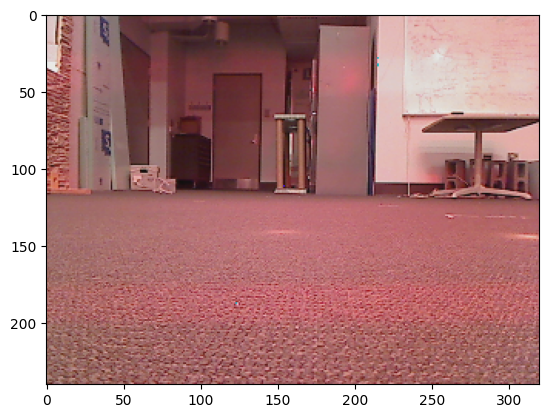

In [55]:
print(camd["cam"].shape)

plt.imshow(camd["cam"][:, :, :, 0])

Finding the closest in the past rotation matrix

In [56]:
rots = []
for i in range(len(camd["ts"][0])):
    for j in range(len(vicd["ts"][0])):
        if vicd["ts"][0][j] > camd["ts"][0][i] or j == vicd["ts"].shape[-1] - 1:
            rots.append(vicd["rots"][:, :, j - 1])
            break
print(len(rots), len(camd["ts"][0]))

860 860


Loading Rotations correctly

860


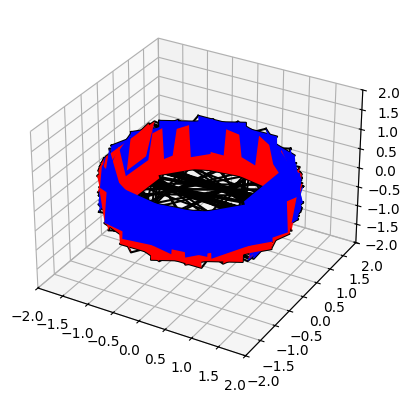

In [57]:
def rotplot(R, currentAxes=None):
	# Plots the orientation of a 3x3 rotation matrix R.
	# You should modify it as you wish for the project.

	lx = 3.0
	ly = 1.5
	lz = 1.0

	x = .5*np.array([[+lx, -lx, +lx, -lx, +lx, -lx, +lx, -lx],
		[+ly, +ly, -ly, -ly, +ly, +ly, -ly, -ly],
		[+lz, +lz, +lz, +lz, -lz, -lz, -lz, -lz]])

	xp = np.dot(R,x);
	ifront = np.array([0, 2, 6, 4, 0])
	iback = np.array([1, 3, 7, 5, 1])
	itop = np.array([0, 1, 3, 2, 0])
	ibottom = np.array([4, 5, 7, 6, 4])
	
	if currentAxes is not None:
		ax = currentAxes
	else:
		fig = plt.figure()
		ax = fig.add_subplot(projection = '3d')

	ax.plot(xp[0,itop], xp[1,itop], xp[2,itop], 'k-')
	ax.plot(xp[0,ibottom], xp[1,ibottom], xp[2,ibottom], 'k-')
	
	rectangleFront = a3.art3d.Poly3DCollection([list(zip(xp[0,ifront], xp[1,ifront],xp[2,ifront]))])
	rectangleFront.set_facecolor('Blue')
	ax.add_collection(rectangleFront)
	
	rectangleBack = a3.art3d.Poly3DCollection([list(zip(xp[0,iback], xp[1,iback],xp[2,iback]))])
	rectangleBack.set_facecolor('Red')
	ax.add_collection(rectangleBack)

	ax.set_xlim3d(-2, 2)
	ax.set_ylim3d(-2, 2)
	ax.set_zlim3d(-2, 2)
	
	return ax

print(len(rots))
axis = rotplot(rots[0])
step = 20
for i in range(0, len(rots), step):
    axis = rotplot(rots[i], axis)

plt.show()

In [58]:
height, width = 240, 320
fov_x, fov_y = 60, 45

# angles_xx = np.linspace(90 - (fov_x / 2), 90 + (fov_x / 2), width) * np.pi / 180
angles_x = np.array([((90 - fov_x / 2) + (i * fov_x / width)) * (np.pi / 180) for i in range(width)])

angles_y = np.linspace(90 - (fov_y / 2), 90 + (fov_y / 2), height) * np.pi / 180
# angles_yy = np.array([((90 - fov_y / 2) + (i * fov_y / height)) * (np.pi / 180) for i in range(height)])
print(angles_x.shape, angles_y.shape)

(320,) (240,)


In [59]:
trigs = np.ones((height, width, 4))

for i in range(height):
    trigs[i, :, 0] = np.cos(angles_x)
    trigs[i, :, 1] = np.sin(angles_x)

for i in range(width):
    trigs[:, i, 2] = np.cos(angles_y)
    trigs[:, i, 3] = np.sin(angles_y)

In [60]:
cartesian = np.ones((height, width, 3))

for i in range(height):
    for j in range(width):
        cartesian[i, j, 0] = trigs[i, j, 3] * trigs[i, j, 1]
        cartesian[i, j, 1] = trigs[i, j, 3] * trigs[i, j, 0]
        cartesian[i, j, 2] = trigs[i, j, 2]
# cartesian[:, :, 0] = np.multiply(trigs[:, :, 3], trigs[:, :, 1])
# cartesian[:, :, 1] = np.multiply(trigs[:, :, 3], trigs[:, :, 0])
# cartesian[:, :, 2] = trigs[:, :, 2]

100%|██████████| 29/29 [00:01<00:00, 23.28it/s]


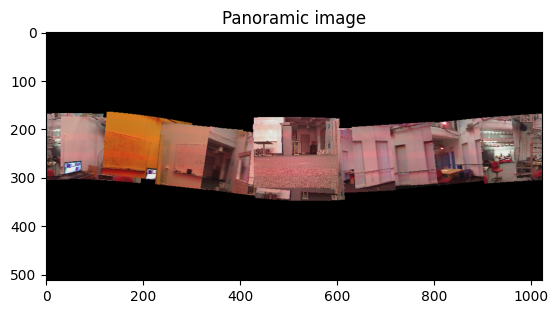

In [61]:
panoramic_width = 1024  # Output panorama width
panoramic_height = 512  # Output panorama height

final_img = np.zeros((panoramic_height, panoramic_width, 3), dtype=np.uint8)
step = 30


for i in tqdm(range(0, len(rots), step)):
    rotated_cartesian = np.dot(cartesian, rots[i])
    # No need to normalize by dividing by the norms
    # norms = np.linalg.norm(rotated_cartesian, axis=2)

    # Azimuth
    theta = np.arctan2(rotated_cartesian[:, :, 1], rotated_cartesian[:, :, 0]) # theta in [-pi, pi]
    # Elevation
    phi = np.arccos(rotated_cartesian[:, :, 2]) # phi in [0, pi]

    # Normalize to the image size
    # From 2pi to panoramic_width
    u = ((theta + np.pi) / (2 * np.pi)) * panoramic_width
    # From pi to panoramic_height
    v = (phi / np.pi) * panoramic_height

    u = u.astype(np.int32)
    v = v.astype(np.int32)
    
    # print(u[0][0], v[0][0])

    for x in range(width):
        for y in range(height):
            final_img[v[y][x]][u[y][x]]= camd["cam"][y, x, :, i]
    
    # del spherical
plt.title("Panoramic image")
plt.imsave(f"panoramic_{dataset}.png", final_img)
plt.imshow(final_img)


Generating panoramic images

In [62]:
final_img = np.zeros((800, 800, 3), dtype=np.uint8)
step = 30

for i in tqdm(range(0, len(rots), step)):
    rotated = np.dot(cartesian, rots[i])
    # print(np.min(rotated[:, :, 0] ** 2 + rotated[:, :, 1] ** 2 + rotated[:, :, 2] ** 2))

    # print(np.max(rotated[:, :, 0]), np.max(rotated[:, :, 1]), np.max(rotated[:, :, 2]))
    # norms = np.linalg.norm(rotated, axis=2)

    # Lambert projection
    lamb = np.zeros((height, width, 2))

    # print(np.max(2 / (1 - rotated[:, :, 2])), np.min(1 - rotated[:, :, 2]))
    # This should be less than 2 and greater than -2 for each coordinate
    lamb[:, :, 0] = np.sqrt(2 / (1 - rotated[:, :, 2])) * rotated[:, :, 0]
    lamb[:, :, 1] = np.sqrt(2 / (1 - rotated[:, :, 2])) * rotated[:, :, 1]

    # Upscaling from 4*4 to 800*800
    lamb *= 200
    lamb = lamb.astype(np.int32)
    # print(np.max(lamb), np.min(lamb))
    # lamb = lamb % 1200
    # print(np.max(lamb[:,:,0]), np.max(lamb[:,:,1]))

    for x in range(width):
        for y in range(height):
            v, u = lamb[y][x]
            final_img[v - 400][u - 400] = camd["cam"][y, x, :, i]
    
    del lamb

plt.title("Lambert image")
plt.imshow(final_img, origin='lower')

 76%|███████▌  | 22/29 [00:03<00:01,  5.87it/s]


KeyboardInterrupt: 

Slower approach

In [26]:
depth = 1
panoramic_width = 1920  # Output panorama width
panoramic_height = 1080  # Output panorama height

def angle_to_radian(angle):
    """
    Convert angle to radian
    input:
    angle: angle in degrees
    output:
    angle in radians
    """
    return (90 - angle) * np.pi / 180

def pixel_to_angles(v, u):
    """
    Convert pixel coordinates to spherical coordinates
    inputs:
    u: x-axis pixel coordinate
    v: y-axis pixel coordinate
    output:
    theta: azimuth angle
    phi: elevation angle
    """
    return angle_to_radian(22.5 - ((u / 240) * 45)), angle_to_radian(((v / 320 ) * 60) - 30)

def angles_to_unit_vector(theta, phi):
    """
    Convert spherical coordinates to unit vector
    inputs:
    theta: azimuth angle
    phi: elevation angle
    output:
    unit vector
    """
    return np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)])

def unit_vector_to_angles(v):
    """
    Convert unit vector to spherical coordinates
    inputs:
    v: unit vector
    output:
    theta: azimuth angle
    phi: elevation angle
    """
    return np.arctan2(v[0], v[1]), np.arccos(v[2])

def rotate_vector(v, r):
    """
    Rotate a vector using a rotation matrix
    inputs:
    v: vector
    r: rotation matrix
    output:
    rotated vector
    """
    return np.dot(v, r)

def project_sphere_to_cylinder(v):
    """
    Project a point on the sphere to the cylinder
    inputs:
    v: point on the sphere
    output:
    point on the cylinder
    """
    theta, phi = unit_vector_to_angles(v)
    # print(theta, phi)
    return int((theta + np.pi) * (panoramic_width / (2 * np.pi))), int(phi * panoramic_height / np.pi)

def pixel_to_cylinder(u, v, r):
    """
    Convert pixel coordinates to cylinder coordinates
    inputs:
    u: x-axis pixel coordinate
    v: y-axis pixel coordinate
    output:
    x, y: (x, y) coordinates on the unwrapped cylinder
    """
    theta, phi = pixel_to_angles(u, v)
    # print(theta, phi)
    v = angles_to_unit_vector(theta, phi)
    # print(v)
    v = rotate_vector(v, r)

    return project_sphere_to_cylinder(v)

final_img = np.zeros((panoramic_height, panoramic_width, 3), dtype=np.uint8)
print(camd["cam"].shape, len(rots))
for i in tqdm(range(0, len(rots), step)):
    rot = rots[i]
    for u in range(camd["cam"].shape[0]):
        for v in range(camd["cam"].shape[1]):
            x, y = pixel_to_cylinder(v, u, rot)        
            final_img[y, x, :] = np.array(camd["cam"][u, v, :, i], dtype=np.uint8)
# print(pixel_to_cylinder(160, 120, np.eye(3)))
plt.imshow(final_img)

(240, 320, 3, 1685) 1685


  4%|▎         | 2/57 [00:00<00:24,  2.28it/s]


KeyboardInterrupt: 